In [1]:
PATH = 'assets/Train.csv'

In [2]:
# !pip install -r requirements.txt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter

In [4]:
import re
import os
import pandas as pd
import numpy as np

In [5]:
# visualization
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [6]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

## **2. Data exploratory analysis**


### **2.1 Data overview**



**Dataset**
The dataset being used is the given competition twitter  dataset. It contains 80K tweets. The tweets have been annotated (0 = Negative, 1 = Positive) and they can be used to detect sentiment.
It contains the following 2 fields:
Sentiment: the emotion of the tweet (0 = negative, 1 = positive)
SentimentText: the text of the tweet 

The core dataset contains 80,000 tweets. The overall distribution of labels is unbalanced (56% pos and 43% neg).

### **2.2 Data Exploration**

The first step is to load the data to global environment.

In [8]:
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv(PATH,encoding=DATASET_ENCODING)

We could see some abnormal words such as <br /><br />, then we should replace them by a null or space value.

### **2.3 Data pre-processing**

**Text Cleaning**

0.Label Encoder

1.Remove html tags

2.Remove special characters

3.Converting every thing to lower case

4.Removing Stop words

5.Stemming

6.Remove extra spaces

7.Lemmatization

In [9]:
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
df.head()

,Sentiment,SentimentText
0,1,@coffeebased thanks so much hehe. Will be twe...
1,0,@cakes4rockstarz at least it'd be a delicious...
2,1,@bretharrison Reaper's my favorite show! Kept ...
3,0,@AGraham1206 Lotsa work.... I'm trying to ge...
4,1,@ 4:30 I will Tweet the #Zazzle galleries for ...


In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Reading contractions.csv and storing it as a dict.
con_path = '../input/semtiment-data/contractions.csv'
contractions = pd.read_csv(con_path,index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):
    tweet = tweet.lower()
    
    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    
    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)
    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)
    
    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)
    
    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

df['SentimentText'] = df.SentimentText.apply(preprocess_apply)

**Stop Words Removal**

We'll remove the stop words for better prediction.

In [12]:
from tqdm import tqdm
nltk.download('punkt')
pbar = tqdm(total=df.shape[0], leave=True, position=0)

def remove_sw(SentimentText):
    tokens = word_tokenize(SentimentText)
    tokens = [w for w in tokens if not w in stop_words]
    pbar.update(1)
    return " ".join(tokens)

df["SentimentText"] = df["SentimentText"].apply(remove_sw)
pbar.close()

  1%|          | 407/79998 [00:00<00:19, 4065.68it/s]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 79998/79998 [00:17<00:00, 4534.27it/s]


**Porter Stemmer**

For this particular dataset the PorterStemmer does not bring better performance, so it is better to skip this step.

In [13]:
pbar = tqdm(total=df.shape[0], leave=True, position=0)
ps = PorterStemmer()

def stem(text):
    pbar.update(1)
    return ' '.join([ps.stem(word) for word in text.split()])

df["SentimentText"] = df["SentimentText"].apply(stem)
pbar.close()

100%|██████████| 79998/79998 [00:20<00:00, 3990.04it/s]


In [14]:
nltk.download('punkt')
#Creating a Lemmatizer for preprocessing
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
df["SentimentText"] = df["SentimentText"].apply(lambda x: re.sub(" +"," ", x))

In [16]:
X = df['SentimentText']
y = df['Sentiment']

Split data to train and test for modeling and performance evaluation.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

print('Training dataset : {} SentimentTexts'.format(X_train.shape[0]))
print('Testing dataset : {} SentimentTexts'.format(X_test.shape[0]))

Training dataset : 71998 SentimentTexts
Testing dataset : 8000 SentimentTexts


In [18]:
y_test.value_counts()

1    4516
0    3484
Name: Sentiment, dtype: int64

## **3. Modeling**

### 3.1 Feature Extraction using TF-IDF algorithm

![TFIDF](https://miro.medium.com/max/532/0*bHkPdhgfnyTs4un_)

In scikit-learn, the TF-IDF algorithm is implemented using **TfidfTransformer**. This transformer needs the count matrix which it will transform later. Hence, we use **CountVectorizer** first.
Alternatively, one can use **TfidfVectorizer**, which is the equivalent of CountVectorizer followed by TfidfTransformer

In [19]:
nltk.download('wordnet')
tfidfVect =    TfidfVectorizer( max_df = 0.5,
                                sublinear_tf=True,
                                lowercase = True, 
                                ngram_range = (1,2), 
                                tokenizer = LemmaTokenizer(),
                                stop_words = 'english',
                                min_df = 1,
                                use_idf = True,
                                # max_features = 1000,
                                strip_accents = 'ascii'
                                )

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
%time features = tfidfVect.fit_transform(X_train)
features.shape

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 22 s, sys: 219 ms, total: 22.2 s
Wall time: 22.3 s


(71998, 301229)

In [21]:
features_test = tfidfVect.transform(X_test)

## Supervised Learning Approach

## TfIdfVectorizer Feature Extraction 
**Naive Bayes Classifier for Multinomial**

In [22]:
#instantiate the model (with the default parameters)
mnb = MultinomialNB()

#fit the model with data (occurs in-place)
mnb.fit(features, y_train)

MultinomialNB()

In [23]:
print("Training accuracy of MultinomialNB using TfIdfVectorizer: {0:.3f}%".format(accuracy_score(y_train, mnb.predict(features))*100))

Training accuracy of MultinomialNB using TfIdfVectorizer: 90.493%


**Stochastic Gradient Descent Classifier**

In [24]:
from sklearn.linear_model import SGDClassifier
#instantiate the model (with the default parameters)
sgd = SGDClassifier()

#fit the model with data (occurs in-place)
sgd.fit(features, y_train)

SGDClassifier()

In [25]:
print("Training accuracy of SGDClassifier using TfIdfVectorizer: {0:.3f}%".format(accuracy_score(y_train, sgd.predict(features))*100))

Training accuracy of SGDClassifier using TfIdfVectorizer: 76.177%


**Logistic Regression**

In [26]:
from sklearn.linear_model import LogisticRegression
#instantiate the model (with the default parameters)
lr = LogisticRegression()

#fit the model with data (occurs in-place)
lr.fit(features, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [27]:
print("Training accuracy of Logistic Regression using TfIdfVectorizer: {0:.3f}%".format(accuracy_score(y_train, lr.predict(features))*100))

Training accuracy of Logistic Regression using TfIdfVectorizer: 86.340%


### 3.1 Feature Extraction using Count Vectorizer

In [28]:
cv=CountVectorizer( max_df = 0.5,
                    lowercase = True, 
                    ngram_range = (1,2), 
                    tokenizer = LemmaTokenizer(),
                    stop_words = 'english',
                    min_df = 1,
                    )

In [29]:
%time bow_features = cv.fit_transform(X_train)
bow_features.shape

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 19.7 s, sys: 77.8 ms, total: 19.8 s
Wall time: 19.7 s


(71998, 301229)

In [30]:
%time bow_features_test = cv.transform(X_test)

CPU times: user 2.13 s, sys: 1.91 ms, total: 2.14 s
Wall time: 2.14 s


**MultinomialNB**

In [31]:
#instantiate the model (with the default parameters)
mnb2 = MultinomialNB()

#fit the model with data (occurs in-place)
mnb2.fit(bow_features, y_train)

MultinomialNB()

In [32]:
print("Training accuracy of MultinomialNB using CountVectorizer: {0:.3f}%".format(accuracy_score(y_train, mnb2.predict(bow_features))*100))

Training accuracy of MultinomialNB using CountVectorizer: 93.437%


**LogisticRegression**

In [33]:
#instantiate the model (with the default parameters)
lr2 = LogisticRegression()

#fit the model with data (occurs in-place)
lr2.fit(bow_features, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [34]:
print("Training accuracy of LogisticRegression using CountVectorizer: {0:.3f}%".format(accuracy_score(y_train, lr2.predict(bow_features))*100))

Training accuracy of LogisticRegression using CountVectorizer: 95.944%


**Stochastic Gradient Descent Classifier**

In [35]:
#instantiate the model (with the default parameters)
sgd2 = SGDClassifier()

#fit the model with data (occurs in-place)
sgd2.fit(bow_features, y_train)

SGDClassifier()

In [36]:
print("Training accuracy of SGDClassifier using CountVectorizer: {0:.3f}%".format(accuracy_score(y_train, sgd2.predict(bow_features))*100))

Training accuracy of SGDClassifier using CountVectorizer: 91.575%


## Evaluation

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [38]:
pred = sgd.predict(features_test)
pred = pd.DataFrame(pred)
print(accuracy_score(y_test, pred))
print(recall_score(y_test, pred))
print(precision_score(y_test, pred))

0.73175
0.87533215234721
0.7140534682080925


In [39]:

pred = mnb.predict(features_test)
pred = pd.DataFrame(pred)
print(accuracy_score(y_test, pred))
print(recall_score(y_test, pred))
print(precision_score(y_test, pred))

0.7265
0.9012400354295838
0.7002752924982795


In [40]:
pred = lr.predict(features_test)
pred = pd.DataFrame(pred)
print(accuracy_score(y_test, pred))
print(recall_score(y_test, pred))
print(precision_score(y_test, pred))

0.752375
0.8215234720992028
0.759467758444217


Text(0.5, 1.0, 'LogisticRegression Confusion Matrix')

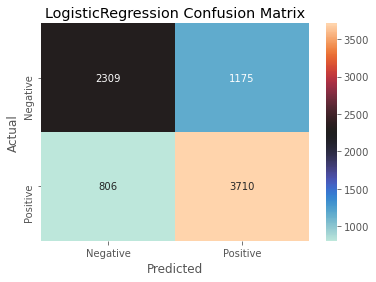

In [41]:
sn.heatmap(confusion_matrix(y_test, pred), annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')

sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LogisticRegression Confusion Matrix')

# 10FOLD CROSS VALIDATION approach

In [42]:
import matplotlib.pyplot as pyplot
def show_metrics(title,accuracy,precision,recall):
    # joined graph
    pyplot.title(title)
    pyplot.plot(accuracy, label='accuracy')
    pyplot.legend()
    pyplot.plot(precision, label='precision')
    pyplot.legend()
    pyplot.plot(recall, label='recall')
    pyplot.legend(loc="center left")
    pyplot.show()
    
    # seperated graphs
    pyplot.title(f"Accuracy")
    pyplot.plot(accuracy, label='accuracy')
    pyplot.legend()
    pyplot.show()
    pyplot.title(f"Precision")
    pyplot.plot(precision, label='precision')
    pyplot.legend()
    pyplot.show()
    pyplot.title(f"Recall:")
    pyplot.plot(recall, label='recall')
    pyplot.legend()
    pyplot.show()

# logistic regression TFIDF

--------------- Fold 1 ------------------
Accuracy: 0.749875 
Precision: 0.7500976181179226 
Recall: 0.8419899189129958 
--------------- Fold 2 ------------------
Accuracy: 0.74275 
Precision: 0.7395833333333334 
Recall: 0.8369661921708185 
--------------- Fold 3 ------------------
Accuracy: 0.750625 
Precision: 0.7395792754187768 
Recall: 0.8523007856341189 
--------------- Fold 4 ------------------
Accuracy: 0.746875 
Precision: 0.7426456263393727 
Recall: 0.8441098317094774 
--------------- Fold 5 ------------------
Accuracy: 0.74675 
Precision: 0.7443346891342243 
Recall: 0.844801055176962 
--------------- Fold 6 ------------------
Accuracy: 0.73975 
Precision: 0.7269155206286837 
Recall: 0.8424408014571949 
--------------- Fold 7 ------------------
Accuracy: 0.754625 
Precision: 0.7569580556644453 
Recall: 0.8423118865866958 
--------------- Fold 8 ------------------
Accuracy: 0.745625 
Precision: 0.7386119257086999 
Recall: 0.8440571939231457 
--------------- Fold 9 -------------

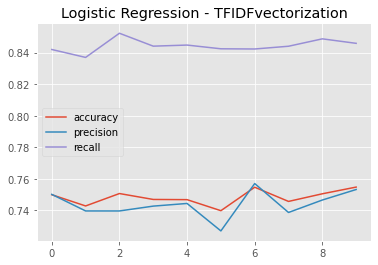

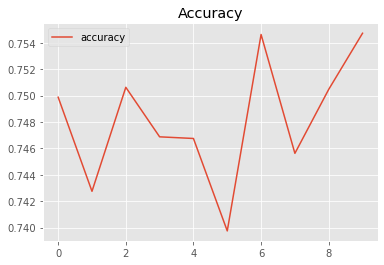

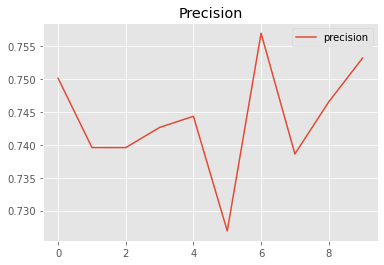

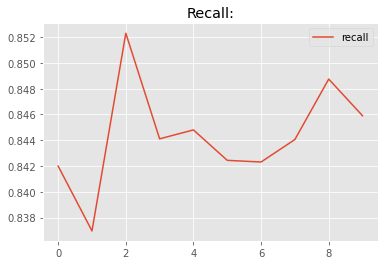

In [43]:
from sklearn.model_selection import KFold
lr_tfidf_fold_models = []
lr_tfidf_fold_accuracy = []
lr_tfidf_fold_precision = []
lr_tfidf_fold_recall = []
max_accuracy = 0
lr_tfidf_best_confusion_matrix = []

k_fold = KFold(n_splits=10, shuffle=False)
counter = 1
tfidf_features = tfidfVect.fit_transform(X)
for train_index, validation_index in k_fold.split(tfidf_features):

    logistic_regression = LogisticRegression(random_state=0, max_iter = 1000)
    X_train = tfidf_features[train_index]
    Y_train = y[train_index]
    logistic_regression.fit(X_train,Y_train)
    
    X_valid = tfidf_features[validation_index]
    Y_valid = y[validation_index]
    Y_valid = Y_valid.values
    predictions = logistic_regression.predict(X_valid)

    lr_tfidf_fold_models.append(logistic_regression)
    lr_tfidf_fold_accuracy.append(accuracy_score(Y_valid, predictions))
    lr_tfidf_fold_precision.append(precision_score(Y_valid, predictions))
    lr_tfidf_fold_recall.append(recall_score(Y_valid, predictions))
    
    print(f'--------------- Fold {counter} ------------------')
    print(f"Accuracy: {lr_tfidf_fold_accuracy[counter-1]} ")
    print(f"Precision: {lr_tfidf_fold_precision[counter-1]} ")
    print(f"Recall: {lr_tfidf_fold_recall[counter-1]} ")
    if max_accuracy < lr_tfidf_fold_accuracy[counter-1]:
        lr_tfidf_best_confusion_matrix = confusion_matrix(Y_valid,predictions)
        max_accuracy = lr_tfidf_fold_accuracy[counter-1]
    counter+=1

    
print('-----------------------------------------')
show_metrics('Logistic Regression - TFIDFvectorization',lr_tfidf_fold_accuracy,lr_tfidf_fold_precision,lr_tfidf_fold_recall)

# logistic regression Count

--------------- Fold 1 ------------------
Accuracy: 0.747625 
Precision: 0.7612982744453575 
Recall: 0.8121849660311199 
--------------- Fold 2 ------------------
Accuracy: 0.741375 
Precision: 0.7513983840894966 
Recall: 0.8067170818505338 
--------------- Fold 3 ------------------
Accuracy: 0.74675 
Precision: 0.7467994310099573 
Recall: 0.8249158249158249 
--------------- Fold 4 ------------------
Accuracy: 0.742 
Precision: 0.7495928338762216 
Recall: 0.8153232949512843 
--------------- Fold 5 ------------------
Accuracy: 0.744375 
Precision: 0.7534412955465587 
Recall: 0.8182018025939767 
--------------- Fold 6 ------------------
Accuracy: 0.741625 
Precision: 0.7375843041079092 
Recall: 0.8217213114754098 
--------------- Fold 7 ------------------
Accuracy: 0.751375 
Precision: 0.7645739910313901 
Recall: 0.818102508178844 
--------------- Fold 8 ------------------
Accuracy: 0.737875 
Precision: 0.7463242907434251 
Recall: 0.805183199285076 
--------------- Fold 9 ---------------

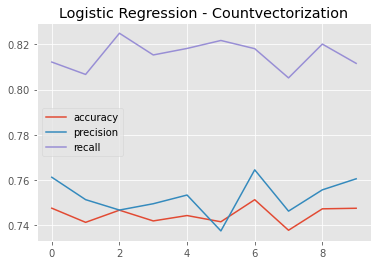

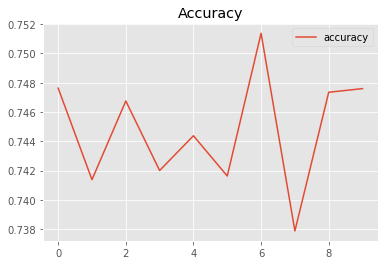

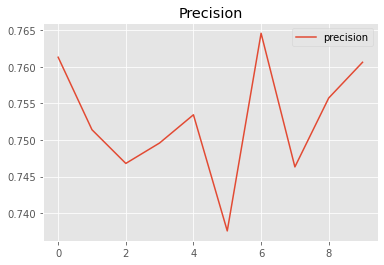

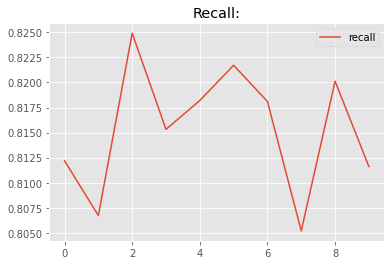

In [45]:
from sklearn.model_selection import KFold
lr_count_fold_models = []
lr_count_fold_accuracy = []
lr_count_fold_precision = []
lr_count_fold_recall = []
max_accuracy = 0
lr_count_best_confusion_matrix = []

k_fold = KFold(n_splits=10, shuffle=False)
counter = 1
count_features = cv.fit_transform(X)
for train_index, validation_index in k_fold.split(count_features):

    logistic_regression = LogisticRegression(random_state=0, max_iter = 1000)
    X_train = count_features[train_index]
    Y_train = y[train_index]
    logistic_regression.fit(X_train,Y_train)
    
    X_valid = count_features[validation_index]
    Y_valid = y[validation_index]
    Y_valid = Y_valid.values
    predictions = logistic_regression.predict(X_valid)

    lr_count_fold_models.append(logistic_regression)
    lr_count_fold_accuracy.append(accuracy_score(Y_valid, predictions))
    lr_count_fold_precision.append(precision_score(Y_valid, predictions))
    lr_count_fold_recall.append(recall_score(Y_valid, predictions))
    
    print(f'--------------- Fold {counter} ------------------')
    print(f"Accuracy: {lr_count_fold_accuracy[counter-1]} ")
    print(f"Precision: {lr_count_fold_precision[counter-1]} ")
    print(f"Recall: {lr_count_fold_recall[counter-1]} ")
    if max_accuracy < lr_count_fold_accuracy[counter-1]:
        lr_count_best_confusion_matrix = confusion_matrix(Y_valid,predictions)
        max_accuracy = lr_count_fold_accuracy[counter-1]
    counter+=1
print('-----------------------------------------')
show_metrics('Logistic Regression - Countvectorization',lr_count_fold_accuracy,lr_count_fold_precision,lr_count_fold_recall)

# Multinomial Navie Bayes TFIDF

--------------- Fold 1 ------------------
Accuracy: 0.723375 
Precision: 0.7010609171800137 
Recall: 0.8978742055665132 
--------------- Fold 2 ------------------
Accuracy: 0.72025 
Precision: 0.6941196698762035 
Recall: 0.8979092526690391 
--------------- Fold 3 ------------------
Accuracy: 0.719 
Precision: 0.688150042625746 
Recall: 0.9059483726150392 
--------------- Fold 4 ------------------
Accuracy: 0.726 
Precision: 0.6994507380707174 
Recall: 0.9023472099202834 
--------------- Fold 5 ------------------
Accuracy: 0.725875 
Precision: 0.7019890260631001 
Recall: 0.8999780171466256 
--------------- Fold 6 ------------------
Accuracy: 0.713125 
Precision: 0.6773811537810861 
Recall: 0.9116575591985429 
--------------- Fold 7 ------------------
Accuracy: 0.7275 
Precision: 0.704750553379874 
Recall: 0.9027262813522355 
--------------- Fold 8 ------------------
Accuracy: 0.73025 
Precision: 0.6992778541953233 
Recall: 0.9086237712243074 
--------------- Fold 9 ------------------
Ac

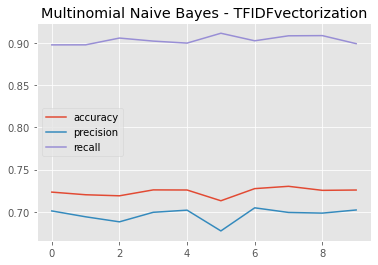

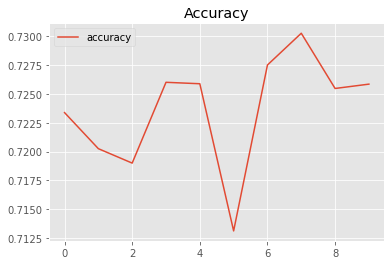

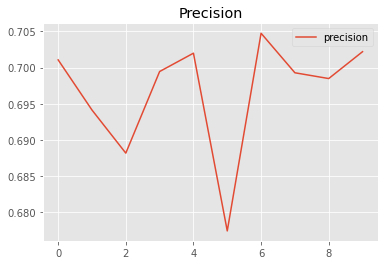

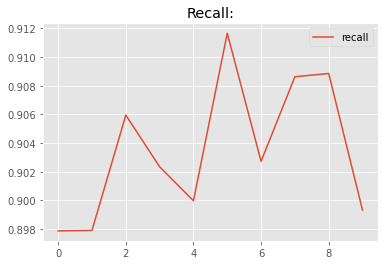

In [46]:
from sklearn.model_selection import KFold
nb_tfidf_fold_models = []
nb_tfidf_fold_accuracy = []
nb_tfidf_fold_precision = []
nb_tfidf_fold_recall = []
max_accuracy = 0
nb_tfidf_best_confusion_matrix = []

k_fold = KFold(n_splits=10, shuffle=False)
counter = 1
tfidf_features = tfidfVect.fit_transform(X)
for train_index, validation_index in k_fold.split(tfidf_features):

    mnbayes = MultinomialNB()
    X_train = tfidf_features[train_index]
    Y_train = y[train_index]
    mnbayes.fit(X_train,Y_train)
    
    X_valid = tfidf_features[validation_index]
    Y_valid = y[validation_index]
    Y_valid = Y_valid.values
    predictions = mnbayes.predict(X_valid)

    nb_tfidf_fold_models.append(mnbayes)
    nb_tfidf_fold_accuracy.append(accuracy_score(Y_valid, predictions))
    nb_tfidf_fold_precision.append(precision_score(Y_valid, predictions))
    nb_tfidf_fold_recall.append(recall_score(Y_valid, predictions))
    
    print(f'--------------- Fold {counter} ------------------')
    print(f"Accuracy: {nb_tfidf_fold_accuracy[counter-1]} ")
    print(f"Precision: {nb_tfidf_fold_precision[counter-1]} ")
    print(f"Recall: {nb_tfidf_fold_recall[counter-1]} ")
    if max_accuracy < nb_tfidf_fold_accuracy[counter-1]:
        nb_tfidf_best_confusion_matrix = confusion_matrix(Y_valid,predictions)
        max_accuracy = nb_tfidf_fold_accuracy[counter-1]
    counter+=1
    
print('-----------------------------------------')
show_metrics('Multinomial Naive Bayes - TFIDFvectorization',nb_tfidf_fold_accuracy,nb_tfidf_fold_precision,nb_tfidf_fold_recall)

# Multinomial Navie Bayes Count

--------------- Fold 1 ------------------
Accuracy: 0.735125 
Precision: 0.7635893011216566 
Recall: 0.7758053911900066 
--------------- Fold 2 ------------------
Accuracy: 0.733625 
Precision: 0.7574569997822774 
Recall: 0.7737989323843416 
--------------- Fold 3 ------------------
Accuracy: 0.74075 
Precision: 0.7561867871745211 
Recall: 0.7887766554433221 
--------------- Fold 4 ------------------
Accuracy: 0.729125 
Precision: 0.7520927237604637 
Recall: 0.7759078830823738 
--------------- Fold 5 ------------------
Accuracy: 0.73175 
Precision: 0.7579987116169208 
Recall: 0.7759947241151901 
--------------- Fold 6 ------------------
Accuracy: 0.7245 
Precision: 0.7360811394044022 
Recall: 0.7766393442622951 
--------------- Fold 7 ------------------
Accuracy: 0.736625 
Precision: 0.7646304997864161 
Recall: 0.7808069792802618 
--------------- Fold 8 ------------------
Accuracy: 0.729 
Precision: 0.75185508511567 
Recall: 0.7696604110813227 
--------------- Fold 9 ------------------

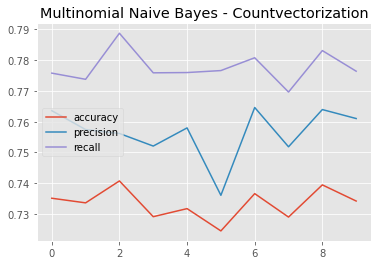

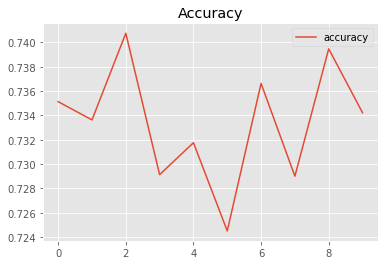

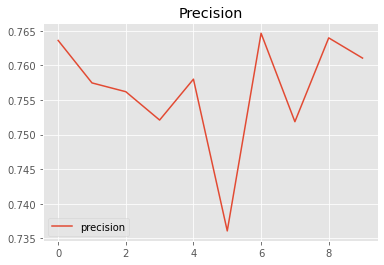

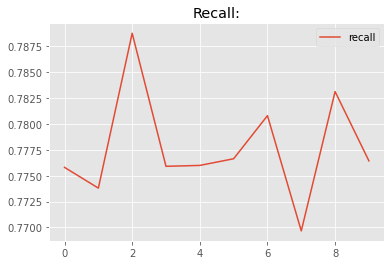

In [47]:
from sklearn.model_selection import KFold
nb_count_fold_models = []
nb_count_fold_accuracy = []
nb_count_fold_precision = []
nb_count_fold_recall = []
max_accuracy = 0
nb_count_best_confusion_matrix = []

k_fold = KFold(n_splits=10, shuffle=False)
counter = 1
count_features = cv.fit_transform(X)
for train_index, validation_index in k_fold.split(count_features):

    mnbayes = MultinomialNB()
    X_train = count_features[train_index]
    Y_train = y[train_index]
    mnbayes.fit(X_train,Y_train)
    
    X_valid = count_features[validation_index]
    Y_valid = y[validation_index]
    Y_valid = Y_valid.values
    predictions = mnbayes.predict(X_valid)

    nb_count_fold_models.append(mnbayes)
    nb_count_fold_accuracy.append(accuracy_score(Y_valid, predictions))
    nb_count_fold_precision.append(precision_score(Y_valid, predictions))
    nb_count_fold_recall.append(recall_score(Y_valid, predictions))
    
    print(f'--------------- Fold {counter} ------------------')
    print(f"Accuracy: {nb_count_fold_accuracy[counter-1]} ")
    print(f"Precision: {nb_count_fold_precision[counter-1]} ")
    print(f"Recall: {nb_count_fold_recall[counter-1]} ")
    if max_accuracy < nb_count_fold_accuracy[counter-1]:
        nb_count_best_confusion_matrix = confusion_matrix(Y_valid,predictions)
        max_accuracy = nb_count_fold_accuracy[counter-1]
    counter+=1
    
print('-----------------------------------------')
show_metrics('Multinomial Naive Bayes - Countvectorization',nb_count_fold_accuracy,nb_count_fold_precision,nb_count_fold_recall)

# SGD TFIDF

--------------- Fold 1 ------------------
Accuracy: 0.731125 
Precision: 0.7053115423901941 
Recall: 0.9079552925706772 
--------------- Fold 2 ------------------
Accuracy: 0.718 
Precision: 0.6908006814310051 
Recall: 0.9019128113879004 
--------------- Fold 3 ------------------
Accuracy: 0.71375 
Precision: 0.6815970474752558 
Recall: 0.9120089786756453 
--------------- Fold 4 ------------------
Accuracy: 0.71975 
Precision: 0.691478612327383 
Recall: 0.9092116917626218 
--------------- Fold 5 ------------------
Accuracy: 0.723125 
Precision: 0.6967296021577882 
Recall: 0.9085513299626291 
--------------- Fold 6 ------------------
Accuracy: 0.713375 
Precision: 0.677310356479135 
Recall: 0.9127959927140255 
--------------- Fold 7 ------------------
Accuracy: 0.7295 
Precision: 0.7040971168437026 
Recall: 0.9107960741548528 
--------------- Fold 8 ------------------
Accuracy: 0.71725 
Precision: 0.6880733944954128 
Recall: 0.9048257372654156 
--------------- Fold 9 ------------------


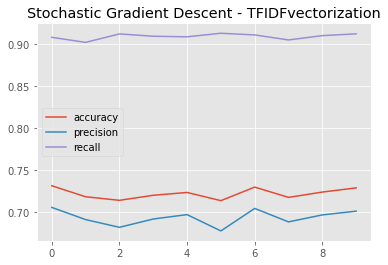

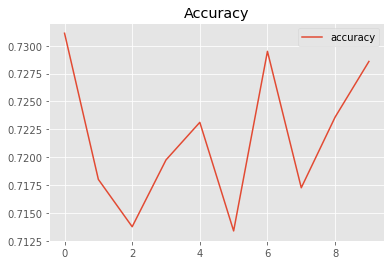

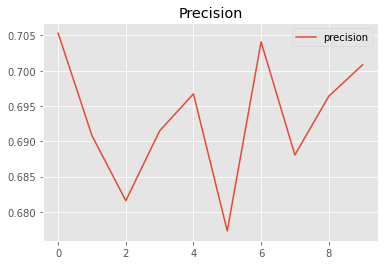

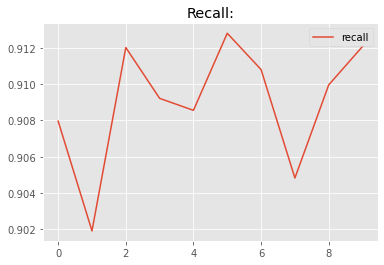

In [48]:
from sklearn.model_selection import KFold
sgd_tfidf_fold_models = []
sgd_tfidf_fold_accuracy = []
sgd_tfidf_fold_precision = []
sgd_tfidf_fold_recall = []
max_accuracy = 0
sgd_tfidf_best_confusion_matrix = []

k_fold = KFold(n_splits=10, shuffle=False)
counter = 1
tfidf_features = tfidfVect.fit_transform(X)
for train_index, validation_index in k_fold.split(tfidf_features):

    sgd = SGDClassifier()
    X_train = tfidf_features[train_index]
    Y_train = y[train_index]
    sgd.fit(X_train,Y_train)
    
    X_valid = tfidf_features[validation_index]
    Y_valid = y[validation_index]
    Y_valid = Y_valid.values
    predictions = sgd.predict(X_valid)

    sgd_tfidf_fold_models.append(sgd)
    sgd_tfidf_fold_accuracy.append(accuracy_score(Y_valid, predictions))
    sgd_tfidf_fold_precision.append(precision_score(Y_valid, predictions))
    sgd_tfidf_fold_recall.append(recall_score(Y_valid, predictions))
    
    print(f'--------------- Fold {counter} ------------------')
    print(f"Accuracy: {sgd_tfidf_fold_accuracy[counter-1]} ")
    print(f"Precision: {sgd_tfidf_fold_precision[counter-1]} ")
    print(f"Recall: {sgd_tfidf_fold_recall[counter-1]} ")
    if max_accuracy < sgd_tfidf_fold_accuracy[counter-1]:
        sgd_tfidf_best_confusion_matrix = confusion_matrix(Y_valid,predictions)
        max_accuracy = sgd_tfidf_fold_accuracy[counter-1]
    counter+=1
    
print('-----------------------------------------')
show_metrics('Stochastic Gradient Descent - TFIDFvectorization',sgd_tfidf_fold_accuracy,sgd_tfidf_fold_precision,sgd_tfidf_fold_recall)

# SGD Count 

--------------- Fold 1 ------------------
Accuracy: 0.7465 
Precision: 0.7458777885548011 
Recall: 0.8426473811089196 
--------------- Fold 2 ------------------
Accuracy: 0.7415 
Precision: 0.7405866032500991 
Recall: 0.8311832740213523 
--------------- Fold 3 ------------------
Accuracy: 0.740125 
Precision: 0.73203125 
Recall: 0.8413019079685746 
--------------- Fold 4 ------------------
Accuracy: 0.7385 
Precision: 0.7342481638964051 
Recall: 0.8412311780336581 
--------------- Fold 5 ------------------
Accuracy: 0.738375 
Precision: 0.7378001549186677 
Recall: 0.8375467135634206 
--------------- Fold 6 ------------------
Accuracy: 0.736 
Precision: 0.7224824355971897 
Recall: 0.842896174863388 
--------------- Fold 7 ------------------
Accuracy: 0.747875 
Precision: 0.7489336952307096 
Recall: 0.8425299890948746 
--------------- Fold 8 ------------------
Accuracy: 0.7365 
Precision: 0.7320658565268522 
Recall: 0.8344504021447721 
--------------- Fold 9 ------------------
Accuracy: 

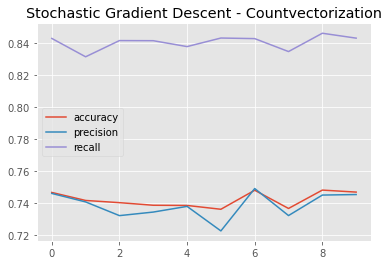

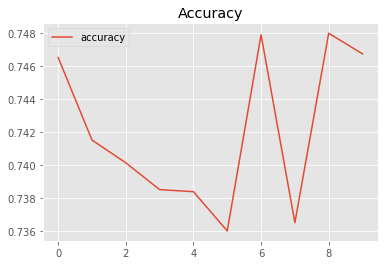

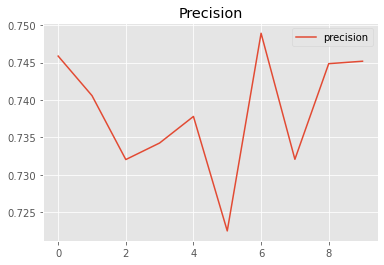

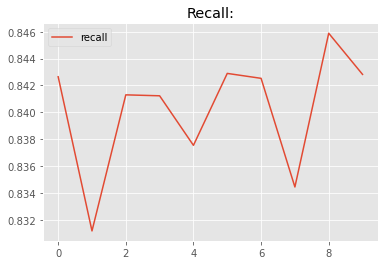

In [49]:
from sklearn.model_selection import KFold
sgd_count_fold_models = []
sgd_count_fold_accuracy = []
sgd_count_fold_precision = []
sgd_count_fold_recall = []
max_accuracy = 0
sgd_count_best_confusion_matrix = []

k_fold = KFold(n_splits=10, shuffle=False)
counter = 1
count_features = cv.fit_transform(X)
for train_index, validation_index in k_fold.split(count_features):

    sgd = SGDClassifier()
    X_train = count_features[train_index]
    Y_train = y[train_index]
    sgd.fit(X_train,Y_train)
    
    X_valid = count_features[validation_index]
    Y_valid = y[validation_index]
    Y_valid = Y_valid.values
    predictions = sgd.predict(X_valid)

    sgd_count_fold_models.append(sgd)
    sgd_count_fold_accuracy.append(accuracy_score(Y_valid, predictions))
    sgd_count_fold_precision.append(precision_score(Y_valid, predictions))
    sgd_count_fold_recall.append(recall_score(Y_valid, predictions))
    
    print(f'--------------- Fold {counter} ------------------')
    print(f"Accuracy: {sgd_count_fold_accuracy[counter-1]} ")
    print(f"Precision: {sgd_count_fold_precision[counter-1]} ")
    print(f"Recall: {sgd_count_fold_recall[counter-1]} ")
    if max_accuracy < sgd_count_fold_accuracy[counter-1]:
        sgd_count_best_confusion_matrix = confusion_matrix(Y_valid,predictions)
        max_accuracy = sgd_count_fold_accuracy[counter-1]
    counter+=1
    
print('-----------------------------------------')
show_metrics('Stochastic Gradient Descent - Countvectorization',sgd_count_fold_accuracy,sgd_count_fold_precision,sgd_count_fold_recall)

# HEATMAPS

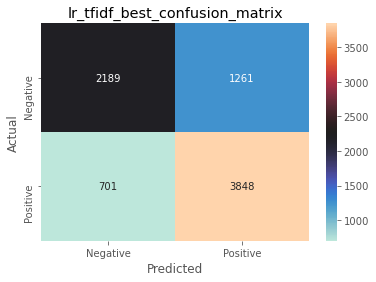

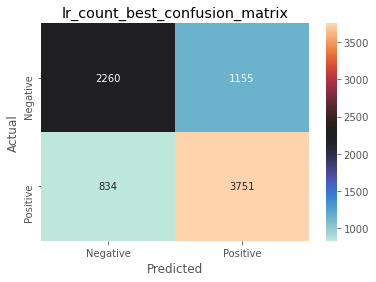

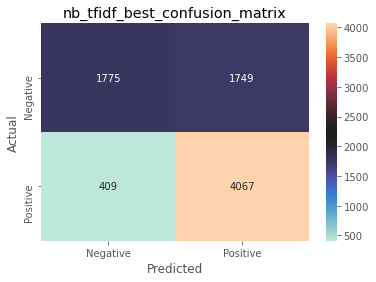

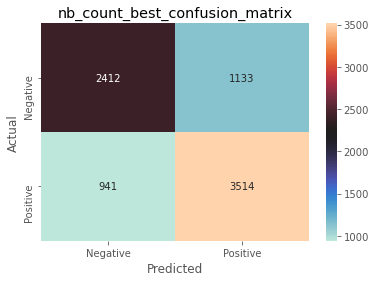

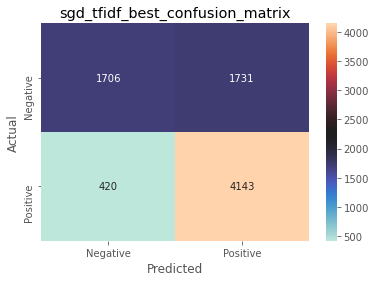

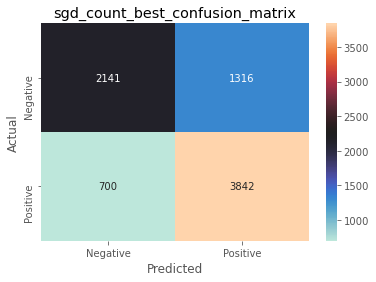

In [53]:
sn.heatmap(lr_tfidf_best_confusion_matrix, annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')
sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression TFIDF')
plt.show()

sn.heatmap(lr_count_best_confusion_matrix, annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')
sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Count')
plt.show()

sn.heatmap(nb_tfidf_best_confusion_matrix, annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')
sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multinomial Naive Bayes TFIDF')
plt.show()

sn.heatmap(nb_count_best_confusion_matrix, annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')
sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multinomial Naive Bayes Count')
plt.show()

sn.heatmap(sgd_tfidf_best_confusion_matrix, annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')
sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Stochastic Gradient Descent TFIDF')
plt.show()

sn.heatmap(sgd_count_best_confusion_matrix, annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')
sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Stochastic Gradient Descent Count')
plt.show()